In [1]:
import os
os.environ['PATH'].split(';')

['C:\\Users\\Zack\\Anaconda3',
 'C:\\Users\\Zack\\Anaconda3\\Library\\mingw-w64\\bin',
 'C:\\Users\\Zack\\Anaconda3\\Library\\usr\\bin',
 'C:\\Users\\Zack\\Anaconda3\\Library\\bin',
 'C:\\Users\\Zack\\Anaconda3\\Scripts',
 'C:\\Users\\Zack\\Anaconda3\\bin',
 'C:\\Users\\Zack\\Anaconda3\\condabin',
 'C:\\Users\\Zack\\Anaconda3',
 'C:\\Users\\Zack\\Anaconda3\\Library\\mingw-w64\\bin',
 'C:\\Users\\Zack\\Anaconda3\\Library\\usr\\bin',
 'C:\\Users\\Zack\\Anaconda3\\Library\\bin',
 'C:\\Users\\Zack\\Anaconda3\\Scripts',
 'C:\\Program Files (x86)\\NVIDIA Corporation\\PhysX\\Common',
 'C:\\Windows\\system32',
 'C:\\Windows',
 'C:\\Windows\\System32\\Wbem',
 'C:\\Windows\\System32\\WindowsPowerShell\\v1.0',
 'C:\\Windows\\System32\\OpenSSH',
 'C:\\Program Files\\NVIDIA Corporation\\NVIDIA NvDLISR',
 'C:\\WINDOWS\\system32',
 'C:\\WINDOWS',
 'C:\\WINDOWS\\System32\\Wbem',
 'C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0',
 'C:\\WINDOWS\\System32\\OpenSSH',
 'C:\\Users\\Zack\\AppData\\Local\\Pro

# Introduction

NCAA college basketball (NCAAB) is an unpredictable sport. In fact, thats one of its main selling points; the famous "March Madness" tournament has become one of sports most spectacular events. It has truly earned its nickname over the years as the amount of teams participating allows for unlikely heros to emerge and defy the odds. What exactly are those odds, though, and how can we predict them more accurately? What are the key factors we can use to tell which teams are more likely to flourish - or flop?

Before March Madness begins, all 350+ Division I basketball teams play a full regular season of about 30 games, beginning in the fall and continuing into early March. The final standings from the regular season will determine which teams play in the tournament. 68 teams are selected and split into 4 regions and given a seeding from 1 to 16 where 1 is the strongest and 16 is the weakest; as such, 1 is considered the "highest" seed while 16 is considered the "lowest" seed. Since there are 68 teams rather than 64, there are 4 play in games of equally matched opponents. Frequently these play in games are between two 16 seeded teams, and play in games are always between teams of seed 11 or greater, meaning there are slightly more teams that have been seeded 11 or lower historically. Regardless of the play-in game outcomes, the teams of each region are paired together such that the sum of their seedings always equals 17, i.e. 1 pairs with 16, 2 pairs with 15, and so on until 8 pairs with 9. In play-in circumstances, the higher seed is paired with the winner of the play-in game but the final seeding will still add to 17 since both of the play-in teams have the same seeding.

For example, heres the starting bracket from 2019. 

![title](2019MarchMadnessBracket.jpg)

You can also see the progression and arrangement of the bracket. It is arranged such that if the higher seeded team wins every game, then every highest seeded team will be paired with the lowest available seeded team. This means that the team seeded 1 would pair with the remaining 8 seeded team; 2 with 7, ect, until 4 pairs with 5. However, the higher seeded team does not always win so this will not usually be the case. 

Another observation is that due to the bracket's arrangement any team in the bracket can play any other team at some point in the tou. This means we will need to be able to create a prediction between any two teams in the tournament as every matchup is therotically possible, though many of them are unlikely.

# Problem Statement

Using the data obtained during the regular season, what are the best strategies for predicting the outcomes of the games? How well can we predict them? We will be comparing different features and using different models to make the predictions. 

# Starting Simple

Usually its a good idea to start simple. One of the most basic models that we can build would be based entirely on the team's given seedings in the tournament. Seedings contain a ton of information because they are based on a very complex set of factors; team performance (wins-loss record), expert opinion, and national rankings. In fact, no 16 seed had managed to win a single tournament game against a 1 seed until 2018, almost 80 years since the tournament began. We should be able to get a model to perform well with just this information.

## Loading Data

First, we need to get some data and load it. This data can be located here: https://www.sports-reference.com/cbb/

In [102]:
#Import Modules
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import log_loss
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.inspection import permutation_importance 
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

output_file_name = 'NCAA_Tourney_2020'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [50]:
#Load Data
data_frames = {}
for dirname, _, filenames in os.walk('Data\MDataFiles_Stage1\.'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        data_frames[filename[:-4]] = pd.read_csv(os.path.join(dirname, filename),encoding = 'ISO-8859-1')

In [94]:
#Get a list of all of the data files we have in the dataset.
data_frames.keys()

dict_keys(['Cities', 'Conferences', 'MConferenceTourneyGames', 'MGameCities', 'MMasseyOrdinals', 'MNCAATourneyCompactResults', 'MNCAATourneyDetailedResults', 'MNCAATourneySeedRoundSlots', 'MNCAATourneySeeds', 'MNCAATourneySlots', 'MPlayers', 'MRegularSeasonCompactResults', 'MRegularSeasonDetailedResults', 'MSampleSubmissionStage1_2020', 'MSeasons', 'MSecondaryTourneyCompactResults', 'MSecondaryTourneyTeams', 'MTeamCoaches', 'MTeamConferences', 'MTeams', 'MTeamSpellings'])

## Loading Seed Data

First we will need to load the tournament seeds. We have them in the file called 'MNCAATourneySeeds' that we just loaded. The file contains the seed stored with a prefix which represents the region.

In [58]:
TourneySeeds = pd.DataFrame(data_frames['MNCAATourneySeeds'].copy())
TourneySeeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


We can see that the seeds are loaded as 'A##' where A represents a letter (W,X,Y, or Z) which represents one of the 4 regions, and the ## represents that teams seeding in that region. We don't need to know the region so we can strip out the team seeding with the following code.

In [59]:
TourneySeeds['SeedN'] = TourneySeeds['Seed'].apply(lambda x: int(x[1:3]))
TourneySeeds.drop('Seed',axis=1,inplace=True)
TourneySeeds.head()

,Season,TeamID,SeedN
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


## Build a Training Dataset

This is all the data we need for the first model. Next, we need a dataset to train the model. The dataframe called 'MNCAATourneyCompactResults' includes one row for every game played in the NCAA tournament from 1985 to 2019. We can use this to build an appropriate training dataset. We will organize our forecasts with the following ID: Season_Team1ID_Team2ID where Team1ID < Team2ID. The following code creates this training dataset.

In [81]:
TourneyCompactResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())
TourneyCompactResults['TeamID1'] = np.minimum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['TeamID2'] = np.maximum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['result'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],1,0)
TourneyCompactResults['result_differential'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],TourneyCompactResults['WScore'] - TourneyCompactResults['LScore'],TourneyCompactResults['LScore'] - TourneyCompactResults['WScore'])
TourneyCompactResults['ID'] = TourneyCompactResults['Season'].astype(str)+ '_' +TourneyCompactResults['TeamID1'].astype(str)+ '_' +TourneyCompactResults['TeamID2'].astype(str)
TourneyCompactResults_Seed = TourneyCompactResults.loc[:, ['ID', 'Season', 'TeamID1', 'TeamID2', 'result']]
TourneyCompactResults_Seed.head()

,ID,Season,TeamID1,TeamID2,result
0,1985_1116_1234,1985,1116,1234,1
1,1985_1120_1345,1985,1120,1345,1
2,1985_1207_1250,1985,1207,1250,1
3,1985_1229_1425,1985,1229,1425,1
4,1985_1242_1325,1985,1242,1325,1


The variable "result" is our target variable. The variable itself is binary and represents a win for Team 1; result is 1 when team 1 is the winner of the game and 0 when team 1 is the loser of the game.

In [82]:
TourneyCompactResults_Seed = (TourneyCompactResults_Seed
                             .merge(TourneySeeds,left_on=['Season','TeamID1'],right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             .rename({'SeedN':'Seed_Team1'},axis=1)
                             .merge(TourneySeeds,left_on=['Season','TeamID2'],right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             .rename({'SeedN':'Seed_Team2'},axis=1)
                             )

TourneyCompactResults_Seed['Seed_Differential'] = TourneyCompactResults_Seed['Seed_Team1'] - TourneyCompactResults_Seed['Seed_Team2'] 
# TourneyCompactResults_Seed['Seed_Differential_Norm'] = (TourneyCompactResults_Seed['SeedN_x'] - TourneyCompactResults_Seed['SeedN_y']) / np.sqrt(np.minimum(TourneyCompactResults_Seed['SeedN_x'], TourneyCompactResults_Seed['SeedN_y']))

TourneyCompactResults_Seed.head()

,ID,Season,TeamID1,TeamID2,result,Seed_Team1,Seed_Team2,Seed_Differential
0,1985_1116_1234,1985,1116,1234,1,9,8,1
1,1985_1120_1345,1985,1120,1345,1,11,6,5
2,1985_1207_1250,1985,1207,1250,1,1,16,-15
3,1985_1229_1425,1985,1229,1425,1,9,8,1
4,1985_1242_1325,1985,1242,1325,1,3,14,-11


In the end it would be nice to have a final testing dataset to see how the models perform in the closest conditions they could be to normal. Therefore, I removed the 2019 season entirely so we can use it for final testing.

In [83]:
TourneyCompactResults_Seed = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 1985][TourneyCompactResults_Seed['Season'] <= 2018]
TourneyCompactResults_Seed_Train = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 1985][TourneyCompactResults_Seed['Season'] <= 2014]
TourneyCompactResults_Seed_Test = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 2015][TourneyCompactResults_Seed['Season'] <= 2018]
TourneyCompactResults_Seed_Train = TourneyCompactResults_Seed_Train.fillna(0)

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [106]:
feature_list_seed = ['Seed_Team1', 'Seed_Differential']

In [85]:
explore_df_seed = TourneyCompactResults_Seed_Train.loc[:, feature_list_seed + ['Season', 'result']]
explore_df_seed.head()

,Seed_Team1,Seed_Differential,Season,result
0,9,1,1985,1
1,11,5,1985,1
2,1,-15,1985,1
3,9,1,1985,1
4,3,-11,1985,1


## Plot variable interactions

Now we can plot the variables using seaborn's pairplot. This will give us a matrix of scatterplots for every variable interaction and a KDE along the diagonal. 

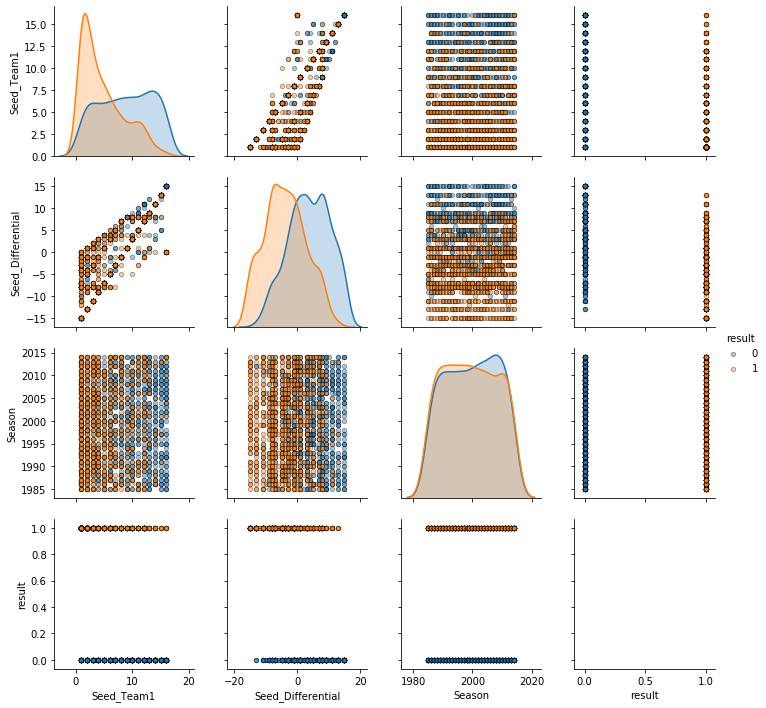

In [99]:
sns.pairplot(explore_df_seed, hue='result',plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})
plt.show()

## Splitting into training/testing and scaling.

Unfortunately, there is a lot of variance in the model outputs introduced based on the train/test split. To help eliminate this problem, we will need to use kfold validation to view the model accuracy across as an average across all of the data. We will set aside 30% of our data for testing and stratify on season. This will ensure we recieve a fairly even distribution of each season in both the training and testing datasets. We also normalize the dataset to help with convergence.

In [117]:
# kf = GroupKFold(n_splits=5)
# kf.get_n_splits(xs_seed, y_seed, TourneyCompactResults_Seed_Train.loc[:,'Season'])

# for train_index, test_index in kf.split(xs_seed, y_seed, TourneyCompactResults_Seed_Train.loc[:,['Season']]):

#     X_train, X_test = np.array(xs_seed)[train_index], np.array(xs_seed)[test_index]
#     y_train, y_test = np.array(y_seed)[train_index], np.array(y_seed)[test_index]
    
    

In [118]:
x_seed = TourneyCompactResults_Seed_Train.loc[:, feature_list_seed]
xs_seed = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x_seed), columns = x_seed.columns)
y_seed = TourneyCompactResults_Seed_Train[['result']]
x_train_seed, x_test_seed, y_train_seed, y_test_seed = train_test_split(xs_seed, y_seed, test_size=0.3, stratify = TourneyCompactResults_Seed_Train['Season'])
x_train_seed.head()

,Seed_Team1,Seed_Differential
544,-1.020861,-0.657054
904,0.689650,0.400525
662,-0.379419,-1.053645
306,-1.234675,-0.392659
493,-0.593233,-0.657054


## Building a Model - Logistic Regression

One of the simplest models for this sort of classification is logistic regression. We will run for different alphas to determine the best alpha and best neg_log_loss produced.

In [124]:
feature_list_seed = ['Seed_Team1', 'Seed_Differential']
for alpha in [0.001,0.01,0.1,1,10, 100, 1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))

0.001 -0.6264594207643996
0.01 -0.5645843084904527
0.1 -0.554309923813772
1 -0.554097167378743
10 -0.5541389269396395
100 -0.554144047319817
1000 -0.5541445693422906


In [125]:
lr = LogisticRegression(solver='lbfgs',C=.1,random_state=42,max_iter=500)
model = lr.fit(x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel())
ypred = model.predict_proba(x_test_seed.loc[:, feature_list_seed])
score = log_loss(y_test_seed, ypred[:,1])
score

0.5522632964884097

Based on the KDE in the pairplot above, seed and seed differential look to be highly correlated with each other. We may capture all the information we need in seed differential alone.

In [126]:
feature_list_seed = ['Seed_Differential']

In [127]:
for alpha in [0.001,0.01,0.1,1,10, 100, 1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))
    # 0.5538911848914796

0.001 -0.645508294787366
0.01 -0.5696679270024687
0.1 -0.5542718272343826
1 -0.553992472391737
10 -0.5540083586684108
100 -0.5540104762843796
1000 -0.5540106934440593


In [128]:
lr = LogisticRegression(solver='lbfgs',C=.1,random_state=42,max_iter=500)
model = lr.fit(x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel())
ypred = model.predict_proba(x_test_seed.loc[:, feature_list_seed])
score = log_loss(y_test_seed, ypred[:,1])
score

0.5525276853275364

We seem to lose a bit of accuracy after removing the seed of team 1 from our features. Additionally, cross validation with the different $\alpha$ reveals that $\alpha>=.1$ works well, with $\alpha=1$ being optimal in this case. This should work well enough to give us a baseline model to build on.

# Adding More Features

## Adding More Data

Before we can start adding more features to try to improve the model, we will need to some work with the MRegularSeasonDetailedResults table that we have. The data includes one row for every regular season game from 2003 to 2019, and denotes the teams involved in the game by the winning team ID and losing team ID. We need to transform the data so we can start looking at season averages for a single team. The easiest way to do this will be to create the final dataset from two simple datasets. First will create a dataset from the winning team's point of view and label the columns accordingly. We set Win = 1 and Loss = 0 since these are the records of every win for every team but none of the losses.

In [129]:
winning_dataset = pd.DataFrame(data_frames['MRegularSeasonDetailedResults'].copy())

winning_dataset = winning_dataset[['Season', 'DayNum'
                                   , 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'
                                   , 'LTeamID', 'LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]
winning_dataset.columns = ['Season', 'DayNum'
                           , 'TeamID', 'Score', 'Loc','NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'
                           , 'OTeamID', 'OScore', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF']

winning_dataset['Win'] = 1
winning_dataset['Loss'] = 0

Next, we will do the same thing but from the perspective of the losing team. As such, WLoc needs to be changed just in case we intend to use it later and want to know if the losing team was at home or away. Win = 0 and Loss = 1 since these are all the records of every loss for every team and none of the wins.

In [130]:
losing_dataset = pd.DataFrame(data_frames['MRegularSeasonDetailedResults'].copy())

losing_dataset.loc[losing_dataset['WLoc'] == 'H', 'Loc'] = 'A'
losing_dataset.loc[losing_dataset['WLoc'] == 'N', 'Loc'] = 'N'
losing_dataset.loc[losing_dataset['WLoc'] == 'A', 'Loc'] = 'H'

losing_dataset = losing_dataset[['Season', 'DayNum'
                                 , 'LTeamID', 'LScore', 'Loc','NumOT', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'
                                 , 'WTeamID', 'WScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
losing_dataset.columns = ['Season', 'DayNum'
                          , 'TeamID', 'Score', 'Loc', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'
                          , 'OTeamID', 'OScore', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF']

losing_dataset['Win'] = 0
losing_dataset['Loss'] = 1

Now we can join the datasets together and we will have 1 row for every team for every game; this will double the amount of rows that we started with.

In [131]:
df = pd.concat([winning_dataset, losing_dataset], ignore_index=True)
df.head()

,Season,DayNum,TeamID,Score,Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID,OScore,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,Win,Loss
0,2003,10,1104,68,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,1328,62,22,53,2,10,16,22,10,22,8,18,9,2,20,1,0
1,2003,10,1272,70,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,1393,63,24,67,6,24,9,20,20,25,7,12,8,6,16,1,0
2,2003,11,1266,73,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,1437,61,22,73,3,26,14,23,31,22,9,12,2,5,23,1,0
3,2003,11,1296,56,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,1457,50,18,49,6,22,8,15,17,20,9,19,4,3,23,1,0
4,2003,11,1400,77,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,1208,71,24,62,6,16,17,27,21,15,12,10,7,1,14,1,0


Finally, we can calculate season averages by team. This data includes regular season games only and will be available prior to any games played in the NCAA tournament.

In [132]:
seasonGroups = (df
               .groupby(['Season','TeamID'])
               )
                
seasonAve = (seasonGroups[['Score','OScore','Win', 'FGM', 'FGA', 'FGM3', 'FGA3','FTM', 'FTA', 'OR', 'DR', 'Ast', 'Stl', 'Blk','TO', 'PF', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OBlk', 'OPF','OTO']]
             .mean()
             .rename({'Win':'WinPCT'},axis=1)
             .reset_index()
             )
seasonAve.head()

,Season,TeamID,Score,OScore,WinPCT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,Stl,Blk,TO,PF,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OBlk,OPF,OTO
0,2003,1102,57.250000,57.000000,0.428571,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,5.964286,1.785714,11.428571,18.750000,19.285714,42.428571,4.750000,12.428571,13.678571,19.250000,9.607143,20.142857,1.571429,18.357143,12.964286
1,2003,1103,78.777778,78.148148,0.481481,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,7.259259,2.333333,12.629630,19.851852,27.777778,57.000000,6.666667,18.370370,15.925926,22.148148,12.037037,22.037037,2.851852,22.444444,15.333333
2,2003,1104,69.285714,65.000000,0.607143,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,6.607143,3.785714,13.285714,18.035714,23.250000,55.500000,6.357143,19.142857,12.142857,17.142857,10.892857,22.642857,3.178571,19.250000,13.857143
3,2003,1105,71.769231,76.653846,0.269231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,9.307692,2.076923,18.653846,20.230769,27.000000,58.961538,6.269231,17.538462,16.384615,24.500000,13.192308,26.384615,4.192308,19.076923,18.807692
4,2003,1106,63.607143,63.750000,0.464286,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,8.357143,3.142857,17.035714,18.178571,21.714286,53.392857,4.785714,15.214286,15.535714,21.964286,11.321429,22.357143,3.178571,16.142857,15.071429


## Advanced Statistics

A lot of research has already been done to determine the strength of basketball teams. A colleague suggested looking into the idea of the "Four Factors"; a term coined to refer to 4 major statistics that are helpful to determine the overall strength of a team. The idea was adapted from here: https://www.basketball-reference.com/about/factors.html 

They are as follows:

## <center> True Shooting Percentage (TS%), Defensive TS% (DTS%), and $\Delta$TS\%  </center>

\begin{equation*}
\mbox{TS%} = \frac{\mbox{Points Scored}}{2 (\mbox{Field Goals Attempted} + .475\mbox{ Free Throws Attempted})}
\end{equation*}

\begin{equation*}
\mbox{DTS%} = \frac{\mbox{Opponent Points Scored}}{2 (\mbox{Opponent Field Goals Attempted} + .475\mbox{ Opponent Free Throws Attempted})}
\end{equation*}

\begin{equation*}
\Delta\mbox{ TS%} = \mbox{TS%} - \mbox{DTS%}
\end{equation*}

TS% is a excellent way to measure the efficiency of a team's offense. $\mbox{Field Goals Attempted} + .475 \mbox{ Free Throws Attempted}$ is an approximate measurement of the total number of posessions that the team has. Using points as the numerator and dividing by two normalizes points to possessions while awarding more credit for 3 pointers and less credit for free throws (1 point). Similarly, DTS% is a good way to measure the efficiency of the defense. $\Delta$TS% measures how much better or worse the team does relative to their opponents with respect to TS%.

In [133]:
seasonAve['TS%'] = seasonAve['Score'] / (2 * (seasonAve['FGA'] + .475 * seasonAve['FTA']))
seasonAve['DTS%'] = seasonAve['OScore'] / (2 * (seasonAve['OFGA'] + .475 * seasonAve['OFTA']))
seasonAve['TS%Diff'] = seasonAve['TS%'] - seasonAve['DTS%']

## <center> Offensive Rebounding (ORB%), Defensive Rebounding (DRB%), and $\Delta$Reb </center>

\begin{equation*}
\mbox{ORB%} = \frac{\mbox{Offensive Rebounds}}{\mbox{Offensive Rebounds} + \mbox{Opponent Defensive Rebounds}}
\end{equation*}

\begin{equation*}
\mbox{DRB%} = \frac{\mbox{Defensive Rebounds}}{\mbox{Defensive Rebounds} + \mbox{Opponent Offensive Rebounds}}
\end{equation*}

\begin{equation*}
\Delta \mbox{ Reb} = \mbox{ORB%} - (1-\mbox{DRB%})
\end{equation*}

Rebounding is essential to basketball. An offensive rebound gives an offense another chance at points which is essentially an additional possession. In this sense, an offensive rebound is similar to a turnover. Similarly, a defensive rebound is the final piece of a successful defense. The more frequently a team secures a defensive rebound means less chances for the opponent to score. Similar to TS% we can create another differential statistic with ORB% and DRB%:


In [134]:
seasonAve['ORB%'] = seasonAve['OR'] / (seasonAve['ODR'] + seasonAve['OR'])
seasonAve['DRB%'] = seasonAve['OOR'] / (seasonAve['OOR'] + seasonAve['DR'])
seasonAve['ORB%Diff'] = seasonAve['ORB%'] - seasonAve['DRB%']

## <center> Turnovers (TOV%), Defensive Turnovers (DTOV%), and $\Delta$TOV </center>

\begin{equation*}
\mbox{TOV%} = \frac{\mbox{Turnovers}}{\mbox{Field Goals Attempted} + .475\mbox{Free Throws Attempted} + \mbox{Turnovers}}
\end{equation*}

\begin{equation*}
\mbox{DTOV%} = \frac{\mbox{Opponent Turnovers}}{\mbox{Opponent Field Goals Attempted} + .475\mbox{Opponent Free Throws Attempted} + \mbox{Opponent Turnovers}}
\end{equation*}

\begin{equation*}
\Delta \mbox{TOV} = \mbox{TOV%} - \mbox{DTOV%}
\end{equation*}

Turnovers are a key piece of the basketball puzzle. Turnovers are a way to steal a possession from another team; A turnover can happen when the ball goes out of bounds or one team steals the ball from another. In either case (or other turnover scenarios), one team effectively loses a possession. Over time, a teams ability to keep the ball in their hands and limit turnovers while forcing opponent turnovers will be able to have more possessions than their opponents, which should directly translate into points. We can measure the team's ability to both limit turnovers and force opponent turnovers as the differential between TOV% and DTOV%:


In [135]:
seasonAve['TOV%'] = 100 * seasonAve['TO'] / (seasonAve['FGA'] + .475 * seasonAve['FTA'] + seasonAve['TO'])
seasonAve['DTOV%'] = 100 * seasonAve['OTO'] / (seasonAve['OFGA'] + .475 * seasonAve['OFTA'] + seasonAve['OTO'])
seasonAve['TOV%Diff'] = seasonAve['TOV%'] - seasonAve['DTOV%']

## <center> Free Throw Efficiency (FT/FGA), Defensive Free Throw Efficiency (DFT/FGA), and $\Delta$FT </center>

\begin{equation*}
\frac{\mbox{FT}}{\mbox{FGA}} = \frac{\mbox{FreeThrows}}{\mbox{FieldGoalsAttempted}}
\end{equation*}

\begin{equation*}
\frac{\mbox{DFT}}{\mbox{FGA}} = \frac{\mbox{OpponentFreeThrowsAttempted}}{\mbox{OpponentFieldGoalsAttempted}}
\end{equation*}

\begin{equation*}
\Delta \mbox{ FT} = \frac{\mbox{FT}}{\mbox{FGA}} - \frac{\mbox{DFT}}{\mbox{FGA}}
\end{equation*}

At first glance these metrics may seem odd but they capture some important information about a teams efficiency to get to the foul line and make their free throws. The metric rewards teams for getting to the free throw line, making the free throw shots, or some combination of both. DFT/FGA captures the teams ability to not let their opponents get to the free throw line. $\Delta$FT captures the teams ability to capitalize on free throws while limiting their opponents. 



In [136]:
seasonAve['FT/FGA'] = seasonAve['FTM'] / seasonAve['FGA']
seasonAve['DFT/FGA'] = seasonAve['OFTA'] / seasonAve['OFGA']
seasonAve['FT/FGADiff'] = seasonAve['FT/FGA'] - seasonAve['DFT/FGA']

## Adding the Features

Now that we have calculated all of the new features we can join them back to the original dataset. We can also calculate overall differential by adding up all the differentials together (and subtracting TOV%Diff because it works in the opposite direction).

In [137]:
TourneyCompactResults = TourneyCompactResults_Seed

TourneyCompactResults = (TourneyCompactResults
                         .merge(seasonAve,left_on=['Season','TeamID1'],right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                         .merge(seasonAve,left_on=['Season','TeamID2'],right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                        )

TourneyCompactResults['Diff_TS%'] = TourneyCompactResults['TS%Diff_x'] - TourneyCompactResults['TS%Diff_y'] 
TourneyCompactResults['Diff_ORB%'] = TourneyCompactResults['ORB%Diff_x'] - TourneyCompactResults['ORB%Diff_y'] 
TourneyCompactResults['Diff_FT/FGA'] = TourneyCompactResults['FT/FGADiff_x'] - TourneyCompactResults['FT/FGADiff_y'] 
TourneyCompactResults['Diff_TOV%'] = (TourneyCompactResults['TOV%Diff_x'] - TourneyCompactResults['TOV%Diff_y'])/100
TourneyCompactResults['Diff_Overall'] = TourneyCompactResults['Diff_TS%'] + TourneyCompactResults['Diff_ORB%'] + TourneyCompactResults['Diff_FT/FGA'] - TourneyCompactResults['Diff_TOV%'] 

TourneyCompactResults = TourneyCompactResults.set_index('ID')


# TourneyCompactResults.head()

In [138]:
TourneyCompactResults = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= 2018]
TourneyCompactResults_Train = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= 2014]
TourneyCompactResults_Test = TourneyCompactResults[TourneyCompactResults['Season'] >= 2015][TourneyCompactResults['Season'] <= 2018]
TourneyCompactResults_Train = TourneyCompactResults_Train.fillna(0)

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
feature_list = ['Diff_TS%', 'Diff_ORB%', 'Diff_TOV%','Diff_FT/FGA','Diff_Overall', 'Seed_Differential']

In [140]:
explore_df = TourneyCompactResults_Train.loc[:, feature_list + ['result', 'Season']]

# explore_df

## Plot variable interactions

C:\Users\Zack\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Zack\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


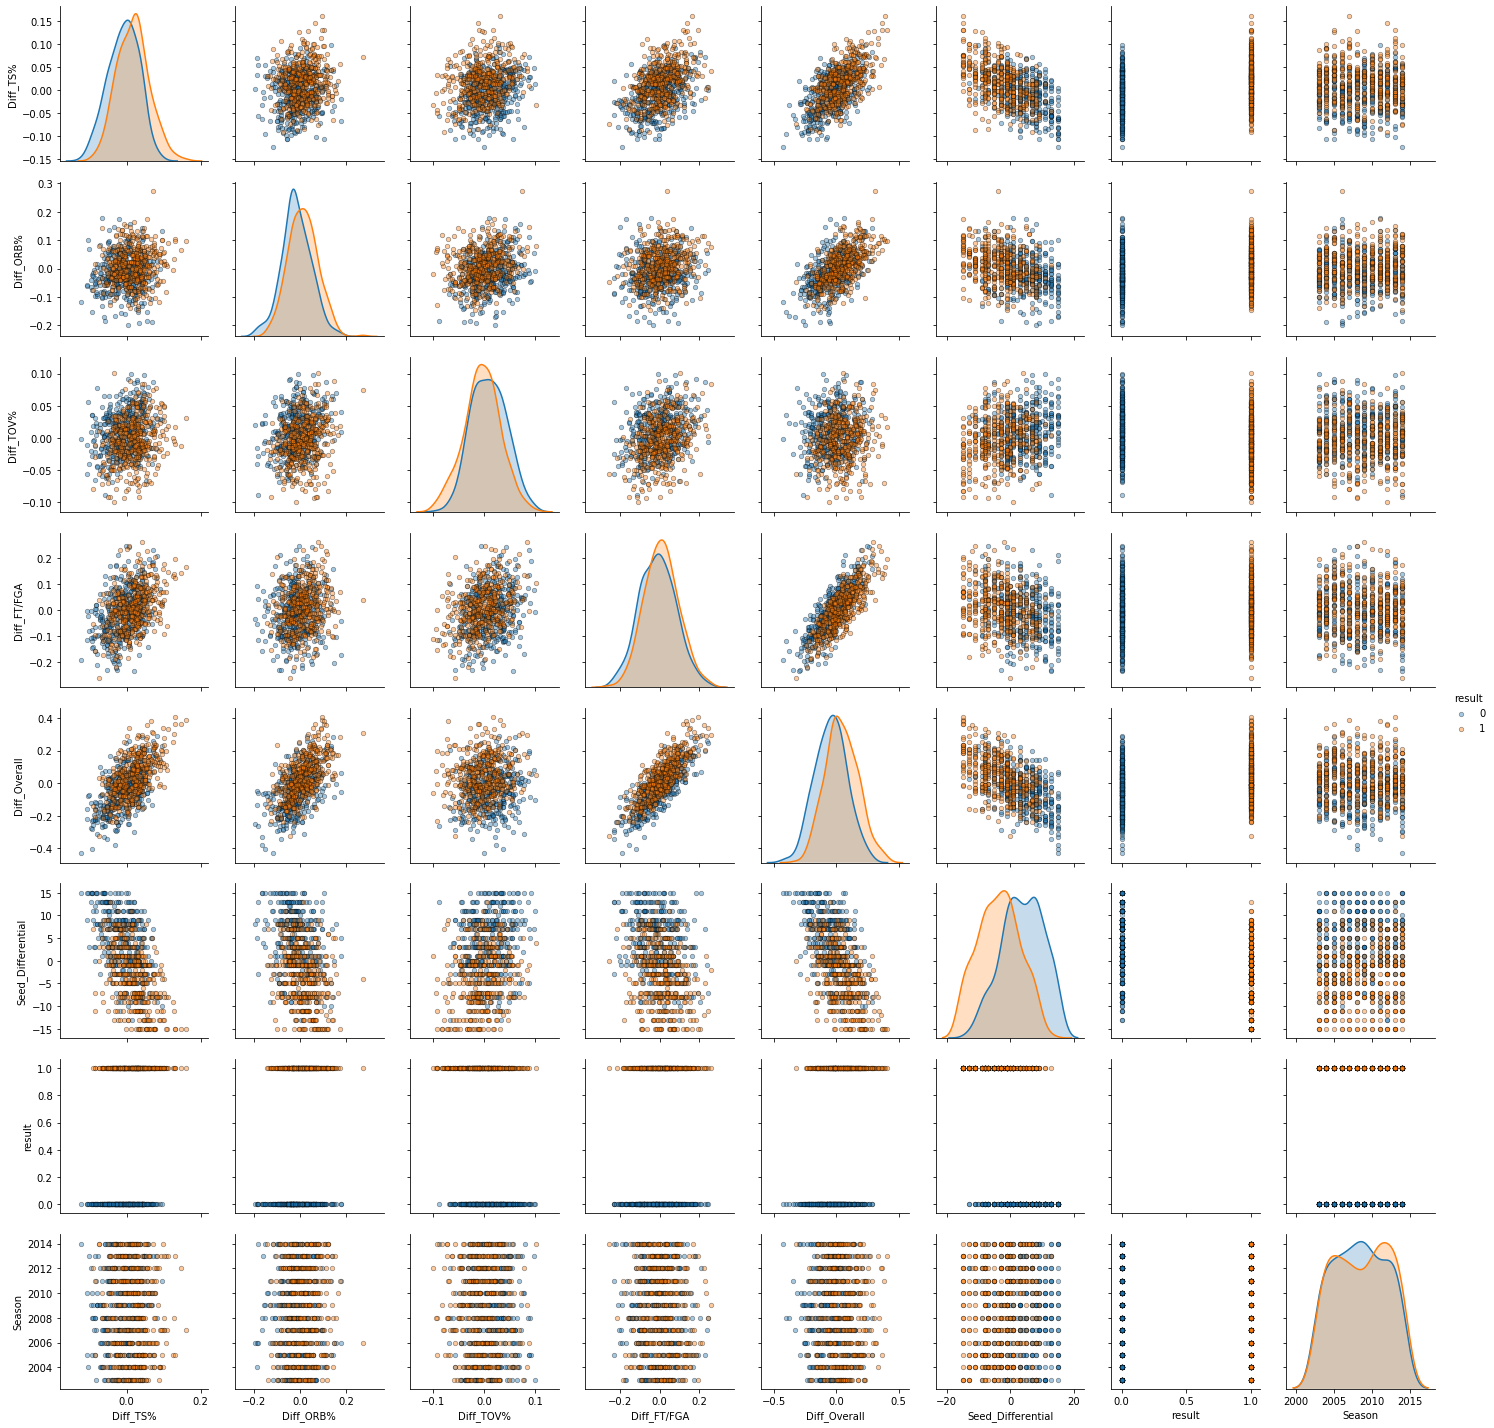

In [141]:
sns.pairplot(explore_df, hue='result', plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})
plt.show()

## Split into Training/Testing

In [144]:
x = TourneyCompactResults_Train.loc[:, feature_list]
xs = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x), columns = x.columns)
y = TourneyCompactResults_Train[['result']]
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.3, stratify = TourneyCompactResults_Train['Season'])
x_train

,Diff_TS%,Diff_ORB%,Diff_TOV%,Diff_FT/FGA,Diff_Overall,Seed_Differential
575,2.092325,2.058870,0.686935,0.257087,1.662548,-1.368071
743,0.197983,0.770454,-0.004755,-0.953448,-0.191642,0.898940
696,-1.865693,-0.522065,-0.885758,-1.054466,-1.321202,0.632233
118,0.924139,-1.484372,0.083703,-1.036690,-1.121716,-0.968010
53,0.699211,-0.716243,-1.332942,-0.132069,0.144607,-0.167889
...,...,...,...,...,...,...
454,-2.200260,-1.104242,-0.882412,-1.643363,-2.100185,1.965768
73,1.468224,-2.828533,-1.214717,-0.619169,-0.977000,0.632233
169,1.263012,-1.552700,-1.012601,-0.254504,-0.240640,-1.101364
239,-1.653033,-0.227318,-0.588725,-0.052026,-0.526601,0.898940


## Building a Model

In [145]:
feature_list = ['Diff_TS%', 'Diff_ORB%', 'Diff_TOV%','Diff_FT/FGA','Diff_Overall', 'Seed_Differential']
for alpha in [0.001,0.01,0.1,1,10,100,1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train.loc[:, feature_list], y_train.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))

0.001 -0.6503755147347509
0.01 -0.5696867986295626
0.1 -0.5435646188260368
1 -0.5439639381656051
10 -0.5442658773316272
100 -0.5443003248302258
1000 -0.5443038153602663


In [146]:
lr = LogisticRegression(solver='lbfgs',C=.1,random_state=42,max_iter=500)
model = lr.fit(x_train.loc[:, feature_list], y_train.values.ravel())
ypred = model.predict_proba(x_test.loc[:, feature_list])
score = log_loss(y_test, ypred[:,1])
score

0.5611581511592515

In [147]:
feature_list = ['Diff_Overall', 'Seed_Differential']

In [148]:
for alpha in [0.001,0.01,0.1,1,10,100,1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train.loc[:, feature_list], y_train.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))

0.001 -0.660696392115671
0.01 -0.5813215931012884
0.1 -0.5487258509400483
1 -0.5474281969494561
10 -0.5475338084887532
100 -0.5475483279364589
1000 -0.5475498220072516


In [149]:
lr = LogisticRegression(solver='lbfgs',C=.1,random_state=42,max_iter=500)
model = lr.fit(x_train.loc[:, feature_list], y_train.values.ravel())
ypred = model.predict_proba(x_test.loc[:, feature_list])
score = log_loss(y_test, ypred[:,1])
score

0.5807680826343489

We seem to lose a fair bit of accuracy when not using the full feature set.

## Trying other models & stacking

Lets try other models alongside logistic regression. We will also try stacking to see if we can eliminate bias. 

In [150]:
feature_list = ['Diff_TS%', 'Diff_ORB%', 'Diff_TOV%','Diff_FT/FGA','Diff_Overall', 'Seed_Differential']
xgb_params = {'min_child_weight':[4,5]
          ,'gamma':[i/10.0 for i in range(3,6)]
          ,'subsample':[i/10.0 for i in range(6,11)]
          ,'colsample_bytree':[i/10.0 for i in range(6,11)]
          ,'max_depth': [2,3,4]}

In [151]:
rf = RandomForestClassifier(n_estimators=100,random_state=42,min_samples_split=100)
lr = LogisticRegression(solver='lbfgs',C=0.1,random_state=42,max_iter=500)
lsvc = SVC(random_state=42,probability=True,kernel='linear')
nnb = KNeighborsClassifier(50)
xgb =  RandomizedSearchCV(XGBClassifier(), xgb_params)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('lr',LogisticRegression(solver='lbfgs',C=0.1,random_state=42,max_iter=500)),
    ('nnb',KNeighborsClassifier(50)),
    ('lsvc',SVC(random_state=42,probability=True,kernel='linear')),
    ('xgb', RandomizedSearchCV(XGBClassifier(), xgb_params))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

model_lr = lr.fit(x_train.loc[:, feature_list], y_train.values.ravel())
model_rf = rf.fit(x_train.loc[:, feature_list], y_train.values.ravel())
model_lsvc = lsvc.fit(x_train.loc[:, feature_list], y_train.values.ravel())
model_nnb = nnb.fit(x_train.loc[:, feature_list], y_train.values.ravel())
model_xgb = xgb.fit(x_train.loc[:, feature_list], y_train.values.ravel())
model_clf = clf.fit(x_train.loc[:, feature_list], y_train.values.ravel())

ypred_lr = model_lr.predict_proba(x_test.loc[:, feature_list])
ypred_rf = model_rf.predict_proba(x_test.loc[:, feature_list])
ypred_lsvc = model_lsvc.predict_proba(x_test.loc[:, feature_list])
ypred_nnb = model_nnb.predict_proba(x_test.loc[:, feature_list])
ypred_xgb = model_xgb.predict_proba(x_test.loc[:, feature_list])
ypred_clf = model_clf.predict_proba(x_test.loc[:, feature_list])

score_lr = log_loss(y_test, ypred_lr[:,1])
score_rf = log_loss(y_test, ypred_rf[:,1])
score_lsvc = log_loss(y_test, ypred_lsvc[:,1])
score_nnb = log_loss(y_test, ypred_nnb[:,1])
score_xgb = log_loss(y_test, ypred_xgb[:,1])
score_clf = log_loss(y_test, ypred_clf[:,1])

print('lr', score_lr)
print('rf', score_rf)
print('lsvc', score_lsvc)
print('nnb', score_nnb)
print('xgb', score_xgb)
print('clf', score_clf)

lr 0.5611581511592515
rf 0.5831507413394311
lsvc 0.5681083156849933
nnb 0.574308110334605
xgb 0.5745852080802633
clf 0.5715450630673586


We can see we're actually getting excellent performance out of logistic regression. We can continue using logistic regression; but we will need to again turn to feature engineering to get more accuracy in our model.

<center> -- BELOW THIS LINE IS NOT FINISHED YET -- </center>

# Team Strength with Regression

The idea was adapted from - https://www.basketball-reference.com/blog/index6aa2.html?p=8070

Our goal is to find each team's strength. One possible way to do it is to create a linear equation for each game:
True shooting percentage:
\begin{equation*}
Team_i - Team_j = \Delta Score
\end{equation*}
Where:
\begin{equation*}
\Delta Score = PointsScored_i - PointsScored_j
\end{equation*}

$Team_i$ and $Team_j$ indicate the strengths of teams i and j. Those are the variables we want to find. The $\Delta Score$ is the margin between the two team for the specific game. 

Another consideration is whether we want to consider a global home court advantage, each teams home strength or not take home court into consideration at all. 

## What to predict?

Can regress on result or result_differential. Which method will give us better results? 